# Grad Project with Transfer Learning - version 6.0

## Preparations

### Import data science and machine learning libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
%matplotlib inline
print(torch.__version__)

2.6.0+cpu


### Set computing device as CPU

In [2]:
device = torch.device("cpu")
print(f"Using Device: {device}")

Using Device: cpu


## Data load in and pre-processing

In [3]:
features = pd.read_csv("/home/sebastian/project/Regression-prediction-of-large-labels-based-on-small-features/data/data.csv", header=None)
features = features.transpose()
features.head()

,0,1,2,3,4,5,6,7,8,9,...,500,501,502,503,504,505,506,507,508,509
0,70.0,200.0,300.0,28.801196,81.105366,6125.0,5690.0,6560.0,870.0,-120.782809,...,-118.949780,-118.499691,-118.020283,-117.503018,-116.936596,-116.305609,-115.588315,-114.752730,-113.749309,-112.495888
1,70.0,200.0,400.0,2.517709,47.612011,3860.0,3840.0,3880.0,40.0,-121.070769,...,-116.630247,-116.579676,-116.529680,-116.480227,-116.431285,-116.382825,-116.334820,-116.287244,-116.240073,-116.193283
2,70.0,200.0,500.0,3.068820,63.245190,3945.0,3920.0,3970.0,50.0,-121.322709,...,-113.516857,-113.319928,-113.096880,-112.840765,-112.541882,-112.186250,-111.752916,-111.208943,-110.499310,-109.524470
3,70.0,200.0,600.0,5.874144,55.115136,4050.0,4000.0,4100.0,100.0,-121.477196,...,-108.600004,-104.475919,-92.225585,-111.170745,-123.172305,-140.835187,-127.837068,-124.087345,-122.231465,-121.097501
4,70.0,200.0,800.0,28.796385,82.338597,3380.0,3140.0,3620.0,480.0,-119.715437,...,-116.835297,-116.822124,-116.809338,-116.796971,-116.785052,-116.773610,-116.762669,-116.752250,-116.742365,-116.733019


In [4]:
print("data dimension:", features.shape)

data dimension: (324, 510)


### Draw original feature-describing histograms

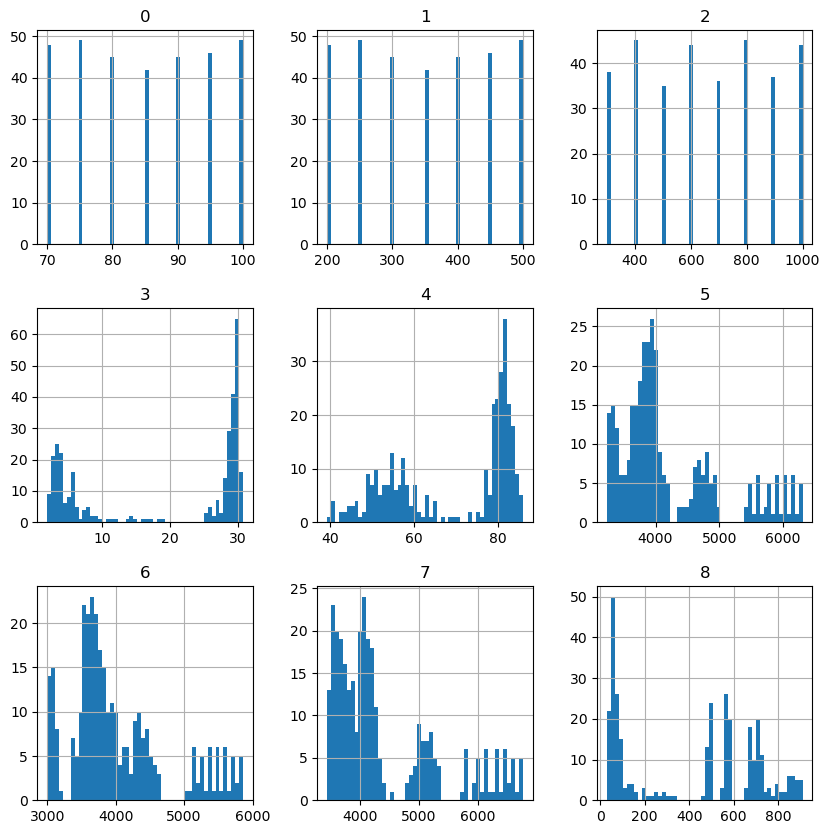

In [5]:
fea = features.iloc[:, :9]
fea.hist(bins=50, figsize=(10,10))
plt.show()

### Set label and transform it into a nparray

In [6]:
labels = np.array(features.iloc[:,9:])
features = np.array(features.iloc[:, 1:9])
features.shape

(324, 8)

### Data standardization using sklearn

In [7]:
input_features = preprocessing.MinMaxScaler().fit_transform(features)
input_labels = preprocessing.StandardScaler().fit_transform(labels)
input_features[0]

array([0.        , 0.        , 0.9330703 , 0.89536728, 0.94127243,
       0.94055944, 0.93975904, 0.95454545])

## Exploratory Data Analysis

### Normalized Data Describing

In [8]:
x = pd.DataFrame(input_features[:, 0:8])
y = pd.DataFrame(input_labels)

### Show labels distribution

### Test features correlations

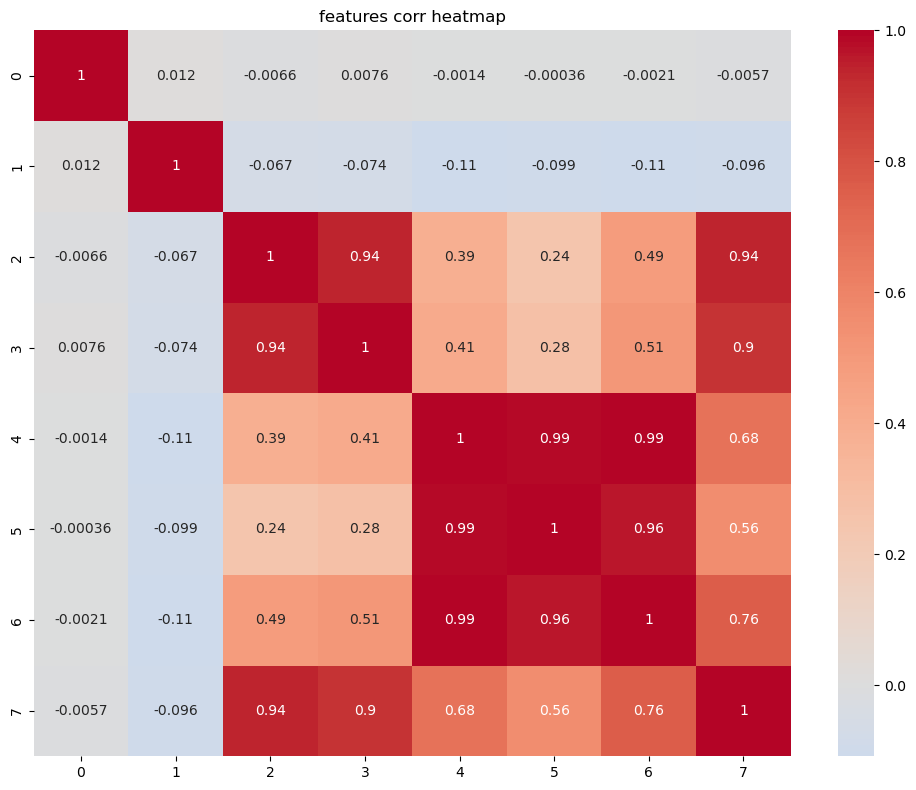

In [9]:
corr_matrix = x.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('features corr heatmap')
plt.tight_layout()
plt.show()

### Delete redundant features

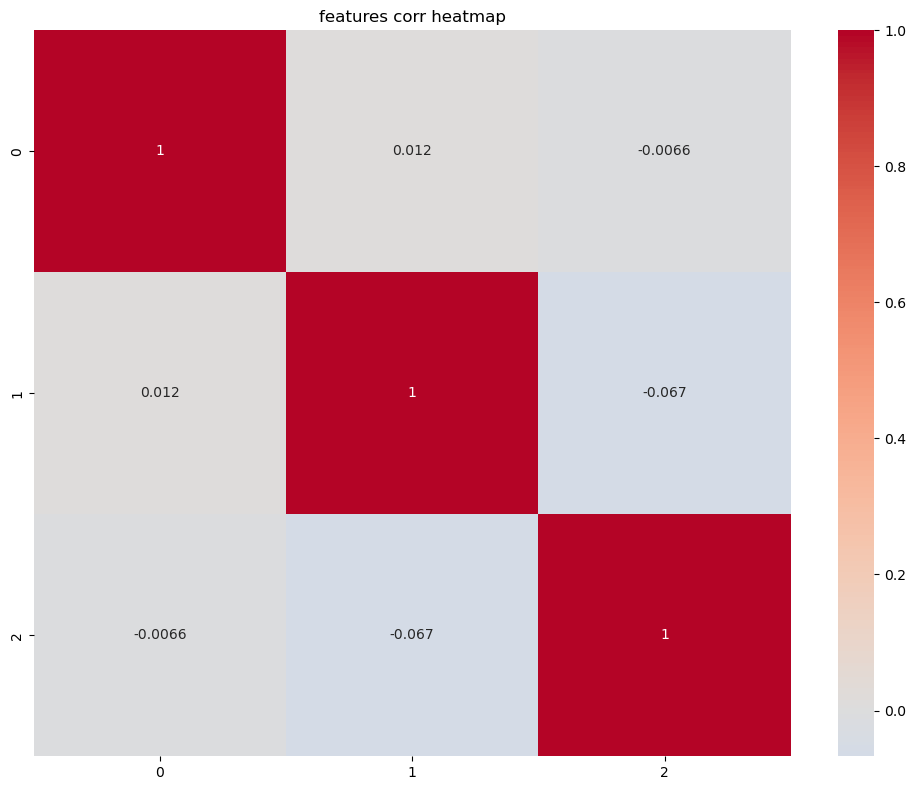

In [10]:
x_reduced = x.drop(columns=[3, 4, 5, 6, 7])
corr_matrix = x_reduced.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('features corr heatmap')
plt.tight_layout()
plt.show()

### Show histograms of standardized-features

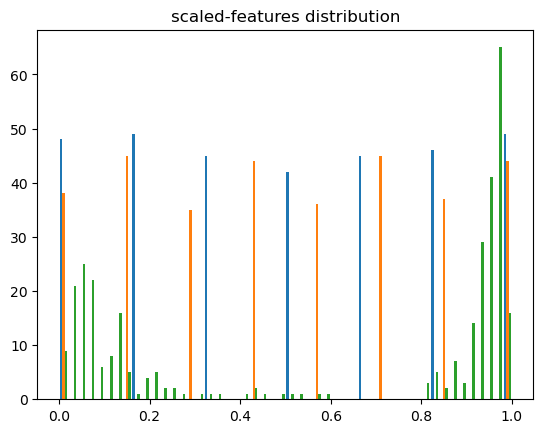

In [13]:
features_reduced = np.delete(input_features, [3, 4, 5, 6, 7], axis=1)
plt.hist(features_reduced, bins=50)
plt.title('scaled-features distribution')
plt.show()

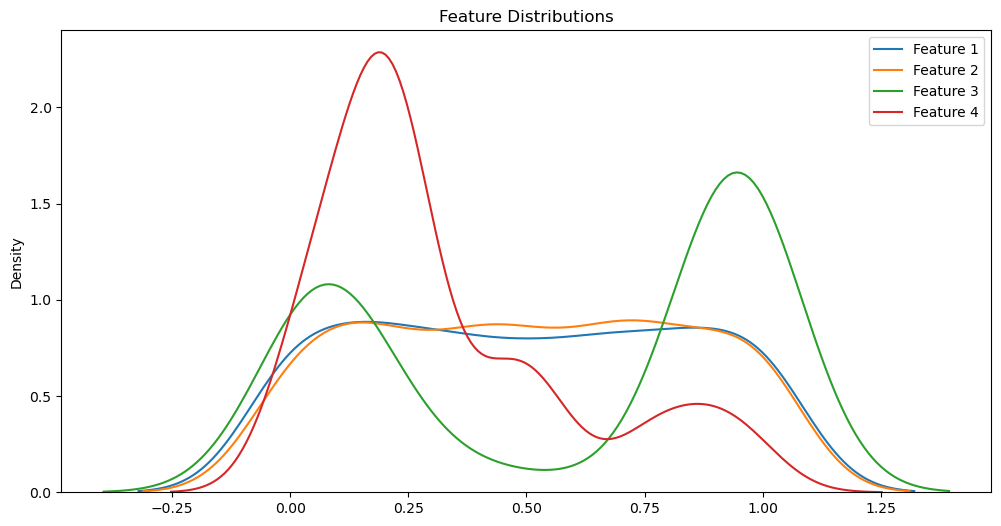

In [51]:
import seaborn as sns

plt.figure(figsize=(12, 6))
for i in range(4):
    sns.kdeplot(features_reduced[:, i], label=f"Feature {i+1}")
plt.legend()
plt.title("Feature Distributions")
plt.show()

324 501


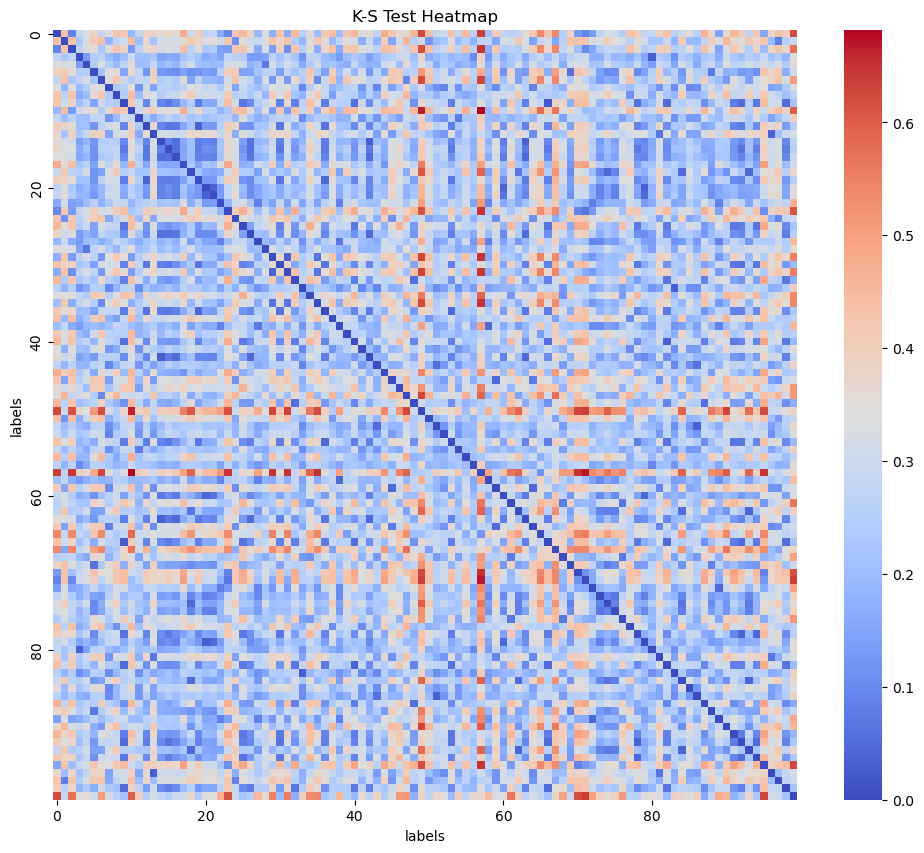

In [53]:
from scipy.stats import ks_2samp

N_samples, N_outputs = input_labels.shape 
print(N_samples, N_outputs)

np.random.seed(42) 
selected_idx = np.random.choice(N_outputs, size=100, replace=False) 
y_selected = input_labels[:, selected_idx] 

ks_matrix = np.zeros((100, 100))  

for i in range(100):
    for j in range(i + 1, 100): 
        ks_stat, _ = ks_2samp(y_selected[:, i], y_selected[:, j])
        ks_matrix[i, j] = ks_stat
        ks_matrix[j, i] = ks_stat  

plt.figure(figsize=(12, 10))
sns.heatmap(ks_matrix, cmap="coolwarm", xticklabels=20, yticklabels=20)  # 20 个 tick，方便展示
plt.title("K-S Test Heatmap")
plt.xlabel("labels")
plt.ylabel("labels")
plt.show()

## Split data set into training and validating

In [22]:
x_train, x_val, y_train, y_val = train_test_split(features_reduced, input_labels, train_size = 0.8, shuffle = True, random_state = 2019)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1, 4)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32).reshape(-1, 1, 4)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

## Modeling

### Set up XGBoost Regression model

In [48]:
xgbr = XGBRegressor(
    objective = "reg:squarederror", 
    n_estimators = 300, 
    max_depth = 8, 
    learning_rate = 0.01,
    subsample = 0.7,
    colsample_bytree = 1.0
)

In [ ]:
xgbr.fit(x_train, y_train)
xgb_train_pred = xgbr.predict(x_train)
xgb_test_pred = xgbr.predict(x_val)